In [2]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [3]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['anxious_last'] = mood.groupby('user_id')['anxious'].shift()
mood.loc[(pd.isnull(mood.anxious_last)), 'anxious_last'] = mood['anxious']
mood_anxious = mood.drop(["content", "bored", "cheerful", "user_id", "response_time"], axis=1)

In [4]:
# Normalize predictors
mood_normz = mood_anxious.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [5]:
# X = predictors, y = target
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]

# Convert float to int
y = y.astype(int)

In [6]:
# Train (80%) & Test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [7]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['anxious'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['anxious'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 0    5768
1    2035
2    1576
3     800
4     294
5     103
Name: anxious, dtype: int64
After OverSampling, counts of label '0': 5768
After OverSampling, counts of label '1': 5768
After OverSampling, counts of label '2': 5768
After OverSampling, counts of label '3': 5768
After OverSampling, counts of label '4': 5768
After OverSampling, counts of label '5': 5768


In [9]:
# Convert oversample dataset to Pandas DataFrame
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res, columns=['anxious'])

In [10]:
# Frank & hall encoding

def multiple_appends(listname, *element):
    listname.extend(element)

y_trainFH = []
for index, row in y_train.iterrows():
    frankhalltrain = []
    if row['anxious'] == 0:
        multiple_appends(frankhalltrain, 0, 0, 0, 0, 0)
    elif row['anxious'] == 1:
        multiple_appends(frankhalltrain, 1, 0, 0, 0, 0)
    elif row['anxious'] == 2:
        multiple_appends(frankhalltrain, 1, 1, 0, 0, 0)
    elif row['anxious'] == 3:
        multiple_appends(frankhalltrain, 1, 1, 1, 0, 0)
    elif row['anxious'] == 4:
        multiple_appends(frankhalltrain, 1, 1, 1, 1, 0)
    elif row['anxious'] == 5:
        multiple_appends(frankhalltrain, 1, 1, 1, 1, 1)
    y_trainFH.append(frankhalltrain)

In [11]:
# Convert oversample dataset to Pandas DataFrame
y_train = pd.DataFrame(data=y_trainFH)

In [12]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [13]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlycontentlast = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlycontentlast = X_test.iloc[:,-1:]

In [14]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 65        
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train model on train set
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 27686 samples, validate on 6922 samples
Epoch 1/100
27686/27686 [==============================] - 0s 16us/step - loss: 0.6607 - accuracy: 0.6309 - val_loss: 0.6303 - val_accuracy: 0.6448
Epoch 2/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.6057 - accuracy: 0.6853 - val_loss: 0.5797 - val_accuracy: 0.6997
Epoch 3/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5758 - accuracy: 0.7001 - val_loss: 0.5691 - val_accuracy: 0.6997
Epoch 4/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5710 - accuracy: 0.7011 - val_loss: 0.5662 - val_accuracy: 0.7046
Epoch 5/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5686 - accuracy: 0.7015 - val_loss: 0.5644 - val_accuracy: 0.7051
Epoch 6/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5671 - accuracy: 0.7058 - val_loss: 0.5635 - val_accuracy: 0.7077
Epoch 7/100
27686/27686 [==============================] - 0s 6us/st

27686/27686 [==============================] - 0s 6us/step - loss: 0.5532 - accuracy: 0.7154 - val_loss: 0.5497 - val_accuracy: 0.7183
Epoch 57/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5531 - accuracy: 0.7165 - val_loss: 0.5497 - val_accuracy: 0.7174
Epoch 58/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5529 - accuracy: 0.7159 - val_loss: 0.5491 - val_accuracy: 0.7188
Epoch 59/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5530 - accuracy: 0.7160 - val_loss: 0.5494 - val_accuracy: 0.7190
Epoch 60/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5528 - accuracy: 0.7171 - val_loss: 0.5491 - val_accuracy: 0.7193
Epoch 61/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5526 - accuracy: 0.7166 - val_loss: 0.5487 - val_accuracy: 0.7188
Epoch 62/100
27686/27686 [==============================] - 0s 5us/step - loss: 0.5526 - accuracy: 0.7166 - val_loss: 0.5486 

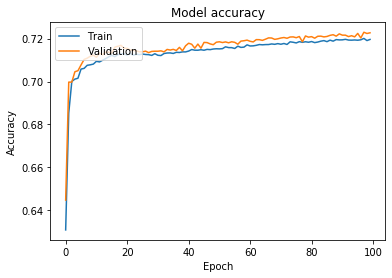

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

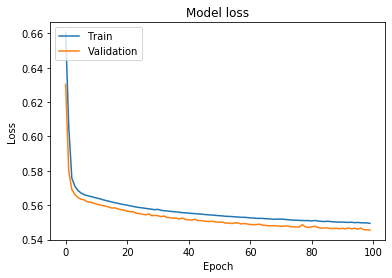

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Predict using X_test
y_pred = model.predict(X_test_nomood)

FH_pred = []
for i in y_pred:
    temp_list = []
    for binary in i:
        if binary >= 0.5:
            temp_list.append(1)
        else:
            temp_list.append(0)
    FH_pred.append(temp_list)

FH_prediction = pd.DataFrame(data=FH_pred, columns=['mood_0', 'mood_1', 'mood_2', 'mood_3', 'mood_4'])

In [19]:
# All unique outcomes
check_pos = []
for ac in FH_pred:
    if ac not in check_pos:
        check_pos.append(ac)
print(check_pos)

[[1, 1, 1, 0, 0], [1, 1, 0, 0, 0], [1, 1, 1, 1, 0], [1, 0, 0, 0, 0], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0]]


In [20]:
pred = FH_prediction.sum(axis=1)
test = y_test['anxious'].values

In [21]:
pred.value_counts()

2    1265
3    1057
1     195
4     103
0      21
5       4
dtype: int64

In [22]:
y_test['anxious'].unique()

array([0, 1, 2, 4, 3, 5])

In [23]:
X_test_onlycontentlast[:5]

,anxious_last
10520,0.0
4114,1.0
6944,0.0
7756,0.0
7079,1.0


In [24]:
# Accuracy score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 12.098298676748582


In [25]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_content = X_test_onlycontentlast['anxious_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_content[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_content[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_content[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_content[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
print("")
print("Accuracy of table is: ", ((same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong)))
print("Accuracy of model is: ", a)

        Same Dif
correct 191 129
wrong   1748 577

Accuracy of table is:  0.12098298676748583
Accuracy of model is:  0.12098298676748583


In [26]:
from collections import Counter
print("Predicted values: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_content))

Predicted values:  Counter({2: 1265, 3: 1057, 1: 195, 4: 103, 0: 21, 5: 4})
True values:  Counter({0: 1438, 1: 513, 2: 370, 3: 212, 4: 90, 5: 22})
Previous mood: Counter({0.0: 1418, 1.0: 523, 2.0: 382, 3.0: 222, 4.0: 84, 5.0: 16})


In [27]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_content[i]:
            same_correct_0 += 1
        if test[i] != X_test_content[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_content[i]:
            same_wrong_0 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_content[i]:
            same_correct_1 += 1
        if test[i] != X_test_content[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_content[i]:
            same_wrong_1 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_content[i]:
            same_correct_2 += 1
        if test[i] != X_test_content[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_content[i]:
            same_wrong_2 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_content[i]:
            same_correct_3 += 1
        if test[i] != X_test_content[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_content[i]:
            same_wrong_3 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_content[i]:
            same_correct_4 += 1
        if test[i] != X_test_content[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_content[i]:
            same_wrong_4 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_content[i]:
            same_correct_5 += 1
        if test[i] != X_test_content[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_content[i]:
            same_wrong_5 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_content))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  12
Same Wrong 0 guesses is:  1236
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  190

Same Correct 1 guesses is:  21
Same Wrong 1 guesses is:  298
Dif Correct 1 guesses is:  15
Dif Wrong 1 guesses is:  179

Same Correct 2 guesses is:  102
Same Wrong 2 guesses is:  111
Dif Correct 2 guesses is:  76
Dif Wrong 2 guesses is:  81

Same Correct 3 guesses is:  55
Same Wrong 3 guesses is:  63
Dif Correct 3 guesses is:  37
Dif Wrong 3 guesses is:  57

Same Correct 4 guesses is:  1
Same Wrong 4 guesses is:  34
Dif Correct 4 guesses is:  1
Dif Wrong 4 guesses is:  54

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  6
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  16


In [28]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [29]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.546
Macro-averaged F1-score is:  0.0715
